###  Normalization Layers


| Normalization Type | Key Idea (Analogy) | Normalized Dimensions | Primary Benefit |
| :--- | :--- | :--- | :--- |
| **Batch Norm** | Compares a feature's activation against the **entire batch's** average. | `(N, H, W)` | 🚀 **Faster & stable training** with larger learning rates (needs a decent batch size). |
| **Layer Norm** | Compares a feature's activation against **all other features in the same sample**. | `(C, H, W)` | 🧠 **Batch-size independent**; perfect for RNNs & Transformers. |
| **Instance Norm** | Adjusts the contrast of **each feature map independently**. | `(H, W)` | 🎨 **Removes instance-specific style**; essential for style transfer & generative art. |
| **Group Norm** | A middle ground: normalizes within **groups of channels** for each sample. | `(Group of C, H, W)` | ⚖️ **Stable & effective** when the batch size is too small for Batch Norm. |
| **FRN** | Normalizes each feature map's magnitude **without shifting its average**. | `(H, W)` | ✨ **Excellent performance** across all batch sizes, from 1 to very large. |

### Helper Function to visualize the norm befor and after

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_norm_effect(before, after, norm_dims):

    # Calculate shared range for visualization
    global_min = min(before.min(), after.min())
    global_max = max(before.max(), after.max())
    bins = np.linspace(global_min, global_max, 100)

    # Calculate means for red lines
    before_mean = np.mean(before)
    after_mean = np.mean(after)

    fig, axs = plt.subplots(2, 2, figsize=(12, 4))

    # Before Normalization
    im_before = axs[0, 0].imshow(before, cmap='gray', vmin=global_min, vmax=global_max)
    axs[0, 0].set_title(f'Before Normalization (dims {norm_dims})')
    axs[0, 0].axis('off')
    fig.colorbar(im_before, ax=axs[0, 0])

    axs[0, 1].hist(before.flatten(), bins=bins, density=True)
    axs[0, 1].axvline(before_mean, color='red', linestyle='--', linewidth=1)
    axs[0, 1].set_title(f'Before Histogram (μ={before_mean:.2f})')
    axs[0, 1].set_xlim(global_min, global_max)

    # After Normalization
    im_after = axs[1, 0].imshow(after, cmap='gray', vmin=global_min, vmax=global_max)
    axs[1, 0].set_title(f'After Normalization (dims {norm_dims})')
    axs[1, 0].axis('off')
    fig.colorbar(im_after, ax=axs[1, 0])

    axs[1, 1].hist(after.flatten(), bins=bins, density=True)
    axs[1, 1].axvline(after_mean, color='red', linestyle='--', linewidth=1)
    axs[1, 1].set_title(f'After Histogram (μ={after_mean:.2f})')
    axs[1, 1].set_xlim(global_min, global_max)

    plt.tight_layout()
    plt.show()

### BatchNorm

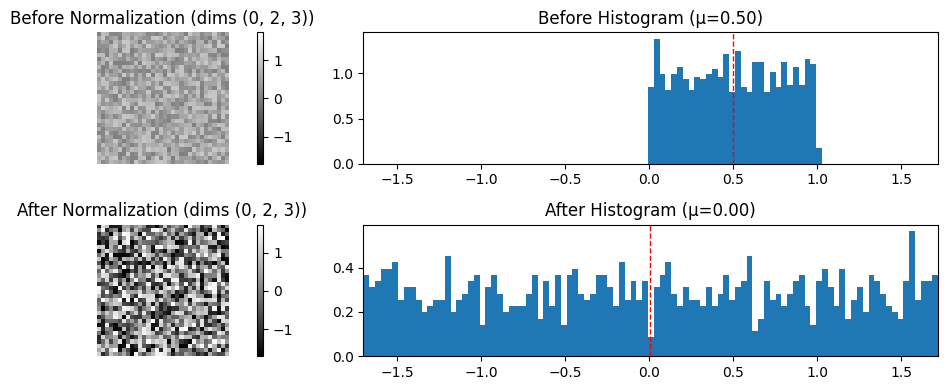

In [ ]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        # gamma and beta are learnable parameters if affine is True
        if self.affine:
            self.gamma = nn.Parameter(torch.ones(num_features))
            self.beta = nn.Parameter(torch.zeros(num_features))
        else:
            self.gamma = None
            self.beta = None

        # running mean and var are used to track the statistics of the batch
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
        else:
            self.register_buffer('running_mean', None)
            self.register_buffer('running_var', None)

    def forward(self, x):
        # broadcast_shape is used to broadcast the mean and var to the shape of the input
        broadcast_shape = [1, -1] + [1] * (x.dim() - 2)
        # norm_dims is used to normalize the mean and var across the feature dimensions
        norm_dims = (0,) + tuple(range(2, x.dim()))
        # if track_running_stats is True, we need to track the running mean and var
        if self.track_running_stats:
            if self.training:
                mean = x.mean(dim=norm_dims)
                # unbiased=False means divide by N instead of N-1 (just like in pytorch)
                var = x.var(dim=norm_dims, unbiased=False)
                # update the running mean and var
                self.running_mean = ( 1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_var = ( 1 - self.momentum) * self.running_var + self.momentum * var
            else:
                # if track_running_stats is False, we use the running mean and var
                mean = self.running_mean
                var = self.running_var
        else:
            # if track_running_stats is False, we use the mean and var of the batch
            mean = x.mean(dim=norm_dims)
            var = x.var(dim=norm_dims, unbiased=False)

        # reshape to match the input shape for broadcasting
        mean = mean.view(broadcast_shape)
        var = var.view(broadcast_shape)

        # normalize the input
        x = (x - mean) / torch.sqrt(var + self.eps)
        if self.affine:
            x = self.gamma.view(broadcast_shape) * x + self.beta.view(broadcast_shape)

        return x

b2d = BatchNorm2d(6)
x = torch.rand(2, 6, 32, 32)
normed = b2d(x)

before = x[0, 0, :, :].detach().cpu().numpy()
after = normed[0, 0, :, :].detach().cpu().numpy()
visualize_norm_effect(before, after, norm_dims=(0, 2, 3))

### Below are Work In Progress

### LayerNorm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, normalize_shape, eps=1e-5, elementwise_affine=True, bias=True):
        super().__init__()
        self.normalize_shape = normalize_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        self.bias = bias

        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(normalize_shape))
            if bias:
                self.bias = nn.Parameter(torch.zeros(normalize_shape))
            else:
                self.register_parameter('bias', None)
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x):
        # Calculate mean and variance across the feature dimensions
        norm_dims = (0,) + tuple(range(2, x.dim()))
        broadcast_shape = [1, -1] + [1] * (x.dim() - 2)

        # Calculate mean and variance across the feature dimensions
        mean = x.mean(dim=norm_dims)
        var = x.var(dim=norm_dims, unbiased=False)

        # Reshape mean and var to match the input shape for broadcasting
        mean = mean.view(broadcast_shape)
        var = var.view(broadcast_shape)

        # Normalize the input
        x = (x - mean) / torch.sqrt(var + self.eps)
        if self.elementwise_affine:

'tensor([0.4892, 0.5069, 0.4986, 0.5008, 0.4929, 0.4902])'

## Set up CIFAR10 Image Classification Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyper parameters
num_epochs = 100
batch_size = 32
learning_rate = 0.001

# transform the data to tensor and normalize it
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Load the CIFAR10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [17]:

class ConvNet(nn.Module):
    def __init__(self, norm_type=None):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.norm_type = norm_type


    def batch_norm_2d(self, x):
        # batch size, channels, height, width
        B, C, H, W = x.shape
        mean = x.mean(dim=0, keepdim=True)
        var = x.var(dim=0, keepdim=True)
        # x - mean / std deviation
        x = (x - mean) / torch.sqrt(var + 1e-5)
        return x

    def layer_norm(self, x):
        # batch size, channels, height, width
        B, C, H, W = x.shape
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + 1e-5)
        return x

    def instance_norm(self, x):
        # batch size, channels, height, width
        B, C, H, W = x.shape
        mean = x.mean(dim=2, keepdim=True)
        var = x.var(dim=2, keepdim=True)
        x = (x - mean) / torch.sqrt(var + 1e-5)
        return x

    def group_norm(self, x):
        # batch size, channels, height, width
        B, C, H, W = x.shape
        group_size = 4
        group = C // group_size
        assert C % group == 0, "channels must be divisible by group"
        # reshape to group, group_size, height, width to calculate mean and var
        mean = x.view(B, group, group_size, H, W).mean(dim=2, keepdim=True)
        var = x.view(B, group, group_size, H, W).var(dim=2, keepdim=True)
        x = (x - mean) / torch.sqrt(var + 1e-5)
        # reshape back to original shape
        x = x.view(B, C, H, W)
        return x

    def frn(self, x):


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if self.norm is not None:
            x = self.norm(x)
        x = self.pool(F.relu(self.conv2(x)))


torch.Size([2, 6, 4])


torch.Size([2, 3, 2, 4])